Still would like to group genes in heatmap based on GO catergories or some other logical way. We may see the genes that don't change as expected in mutant bulks are singletons and that would be one reason to avoid including them in analysis.

In [23]:
library(limma)
library(edgeR)
library(here)
library(ggplot2)
library(gplots)
source(here("R_functions","edgeR_function.R"))
annotations = read.csv("R_functions/gene_descriptions.csv", header = F)
colnames(annotations) = c("gene_id", "description")
annotations$gene_id = substr(annotations$gene_id, 1, 9)

In [2]:
#altering bulk_pb_intersection
bulk_pb_intersection = read.csv("/home/robotmessenger810/sc_analysis/data/pseudo_bulk_data/pb_bulk_sig_intersect_WT_up.csv")

In [3]:
#bulk samples
bulk = counts_to_reads_df("/home/robotmessenger810/sc_analysis/data/bulk_data/Col_h3h3_fals")

[1] "A1_S39_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "A2_S33_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "B1_S32_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "B2_S34_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "C1_S27_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "C2_S35_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "D1_S28_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "D2_S36_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "E1_S29_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "E2_S40_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "F1_S30_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "F2_S37_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "G1_S31_L002_R1_001.trimmed_UMIAligned.outsorted_dedup.bam_counts.gz"
[1] "G2_S25_L002_R1_001.trimmed_UMIAli

In [4]:
colnames(bulk) = c("Col_1","fal7_1","Col_2","fal7_2","Col_3","fal7_3","Col_4","fal7_4","h3h3_1","fal3_1","h3h3_2","fal3_2", "h3h3_3","fal3_3","h3h3_4","fal3_4")

In [5]:
bulk2 = bulk[,-13]
head(bulk2)

,Col_1,fal7_1,Col_2,fal7_2,Col_3,fal7_3,Col_4,fal7_4,h3h3_1,fal3_1,h3h3_2,fal3_2,fal3_3,h3h3_4,fal3_4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AT1G01010,22,23,23,26,8,12,36,8,27,21,4,16,31,21,22
AT1G01020,138,81,102,101,55,67,141,41,102,88,59,75,75,130,102
AT1G01030,21,14,19,19,7,15,18,11,19,14,10,10,16,15,19
AT1G01040,303,145,236,206,74,103,249,42,215,156,111,93,173,187,111
AT1G01046,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0
AT1G01050,597,338,465,469,242,255,544,140,469,303,349,322,294,535,366


In [6]:
#make DGElist
x3 <- DGEList(counts = bulk2, genes = rownames(bulk2))


#reads per library uniquely mapped to a gene:

#make cpm and lcpm
cpm <- cpm(x3)
lcpm <- cpm(x3, log=TRUE)

#keep only genes that are expressed. "Expressed" here means counts observed in at least 3 samples
dim(x3)
keep.exprs <- rowSums(cpm>0)>=3
x3 <- x3[keep.exprs,, keep.lib.sizes=FALSE]
dim(x3) #compare to dim(x) above

#normalize data after removing low expressed genes
x3 <- calcNormFactors(x3)

#cpm, lcpm of normalized values
cpm <- cpm(x3)
lcpm <- cpm(x3, log=TRUE)

de_sub = lcpm[rownames(lcpm) %in% unlist(bulk_pb_intersection$x),]

[1] 32838    15

[1] 26347    15

In [7]:
de_sub_av = cbind(rowMeans(de_sub[,c(1,3,5,7)]), rowMeans(de_sub[,c(9,11,14)]), rowMeans(de_sub[,c(2,4,6,8)]), rowMeans(de_sub[,c(10,12,13, 15)]))

In [8]:
colnames(de_sub_av) = c("wt", "h3h3", "fal7", "fal3")

In [9]:
head(de_sub_av)

,wt,h3h3,fal7,fal3
AT1G02390,3.682254,2.473298,3.824465,3.614386
AT1G05260,7.684157,7.093831,7.438994,7.398936
AT1G15385,4.389574,2.209898,3.223487,3.101048
AT1G19200,4.590667,4.113752,4.745673,4.783227
AT1G30760,5.187268,4.352906,5.711771,5.581185
AT1G35910,4.908952,3.781306,3.927556,3.870882


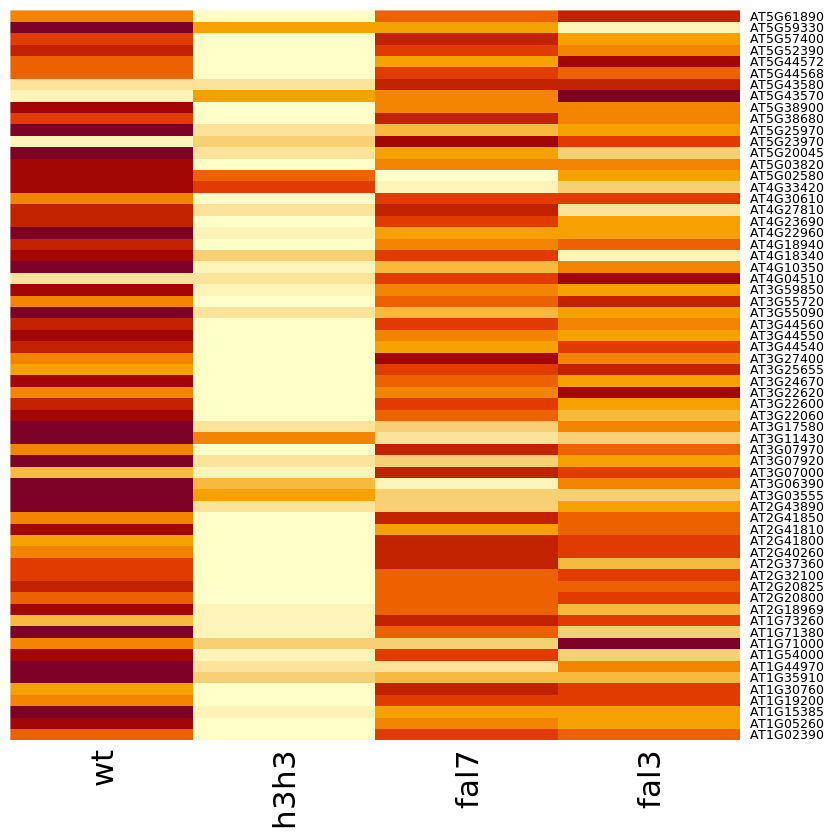

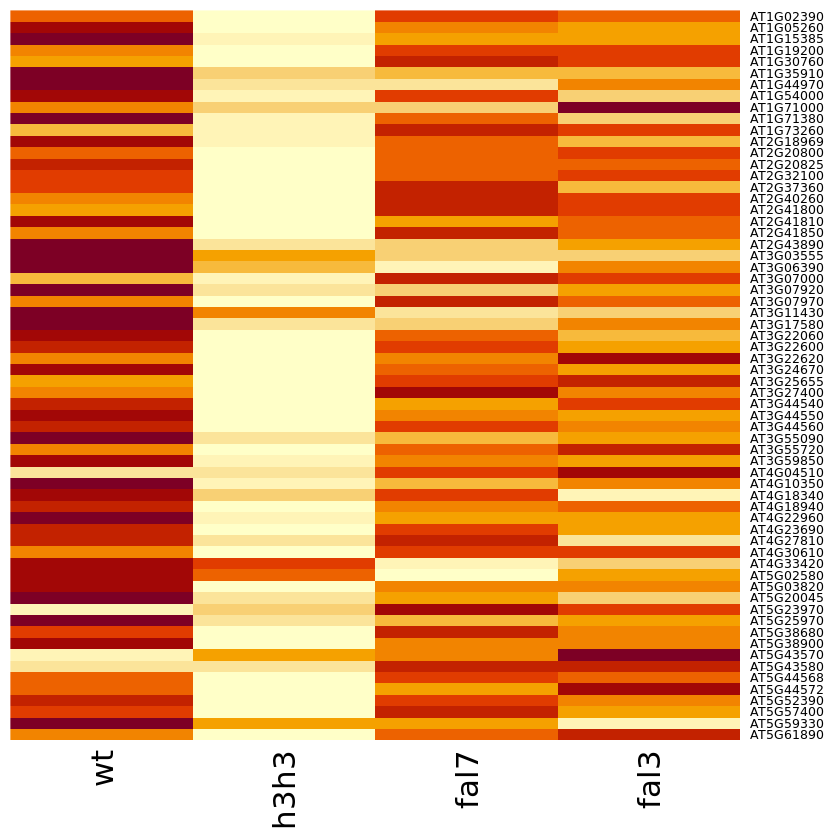

In [21]:
#only WT up genes
mat = de_sub_av-rowMeans(de_sub_av[,(c(1,2))])
hmp = heatmap(mat, Rowv=NA, Colv=NA)
mat = mat[rev(hmp$rowInd),]
hmp = heatmap(mat, Rowv=NA, Colv=NA)

In [50]:
genes = c("AT3G44540","AT3G44550","AT3G44560","AT5G22500","AT1G53830","AT2G41850","AT2G47550","AT3G07970","AT3G24670","AT3G27400","AT4G24780","AT1G28130","AT2G14960","AT2G16580","AT2G28085","AT2G36210",
          "AT3G07390","AT4G14560","AT4G27260","AT4G28640","AT5G54510")
genes
rownames(unlist(mat))

[1] "AT3G44540" "AT3G44550" "AT3G44560" "AT5G22500" "AT1G53830" "AT2G41850"
 [7] "AT2G47550" "AT3G07970" "AT3G24670" "AT3G27400" "AT4G24780" "AT1G28130"
[13] "AT2G14960" "AT2G16580" "AT2G28085" "AT2G36210" "AT3G07390" "AT4G14560"
[19] "AT4G27260" "AT4G28640" "AT5G54510"

[1] "AT5G61890" "AT5G59330" "AT5G57400" "AT5G52390" "AT5G44572" "AT5G44568"
 [7] "AT5G43580" "AT5G43570" "AT5G38900" "AT5G38680" "AT5G25970" "AT5G23970"
[13] "AT5G20045" "AT5G03820" "AT5G02580" "AT4G33420" "AT4G30610" "AT4G27810"
[19] "AT4G23690" "AT4G22960" "AT4G18940" "AT4G18340" "AT4G10350" "AT4G04510"
[25] "AT3G59850" "AT3G55720" "AT3G55090" "AT3G44560" "AT3G44550" "AT3G44540"
[31] "AT3G27400" "AT3G25655" "AT3G24670" "AT3G22620" "AT3G22600" "AT3G22060"
[37] "AT3G17580" "AT3G11430" "AT3G07970" "AT3G07920" "AT3G07000" "AT3G06390"
[43] "AT3G03555" "AT2G43890" "AT2G41850" "AT2G41810" "AT2G41800" "AT2G40260"
[49] "AT2G37360" "AT2G32100" "AT2G20825" "AT2G20800" "AT2G18969" "AT1G73260"
[55] "AT1G71380" "AT1G71000" "AT1G54000" "AT1G44970" "AT1G35910" "AT1G30760"
[61] "AT1G19200" "AT1G15385" "AT1G05260" "AT1G02390"

In [30]:
annotations = annotations[!duplicated(annotations$gene_id),]

In [72]:
genes = as.character(rownames(mat))
rownames(annotations) = annotations$gene_id
vec = as.character(annotations[genes,2])
gene_df = cbind(genes, vec, mat)

In [74]:
write.csv(gene_df, "../data/pseudo_bulk_data/pb_bulk_intersection.csv" )

In [73]:
head(gene_df)

,genes,vec,wt,h3h3,fal7,fal3
AT5G61890,AT5G61890,"Integrase-type DNA-binding superfamily protein encodes a member of the ERF (ethylene response factor) subfamily B-4 of ERF/AP2 transcription factor family. The protein contains one AP2 domain. There are 7 members in this subfamily. Integrase-type DNA-binding superfamily protein; CONTAINS InterPro DOMAIN/s: DNA-binding, integrase-type (InterPro:IPR016177), Pathogenesis-related transcriptional factor/ERF, DNA-binding (InterPro:IPR001471); BEST Arabidopsis thaliana protein match is: Integrase-type DNA-binding superfamily protein (TAIR:AT5G07310.1); Has 1807 Blast hits to 1807 proteins in 277 species: Archae - 0; Bacteria - 0; Metazoa - 736; Fungi - 347; Plants - 385; Viruses - 0; Other Eukaryotes - 339 (source: NCBI BLink).",0.472063376706184,-0.472063376706184,0.634242702068483,0.997880967825536
AT5G59330,AT5G59330,"Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein; FUNCTIONS IN: lipid binding; INVOLVED IN: lipid transport; LOCATED IN: endomembrane system; EXPRESSED IN: shoot apex, shoot, embryo, sepal, leaf; EXPRESSED DURING: 4 anthesis, C globular stage; CONTAINS InterPro DOMAIN/s: Bifunctional inhibitor/plant lipid transfer protein/seed storage (InterPro:IPR016140), Plant lipid transfer protein/Par allergen (InterPro:IPR000528), Plant lipid transfer protein/hydrophobic protein, helical domain (InterPro:IPR013770); BEST Arabidopsis thaliana protein match is: lipid transfer protein 4 (TAIR:AT5G59310.1); Has 543 Blast hits to 543 proteins in 92 species: Archae - 0; Bacteria - 0; Metazoa - 0; Fungi - 0; Plants - 543; Viruses - 0; Other Eukaryotes - 0 (source: NCBI BLink).",0.643095722091438,-0.643095722091437,-0.566532331508288,-1.40499840733229
AT5G57400,AT5G57400,unknown protein; Has 1 Blast hits to 1 proteins in 1 species: Archae - 0; Bacteria - 0; Metazoa - 0; Fungi - 0; Plants - 1; Viruses - 0; Other Eukaryotes - 0 (source: NCBI BLink).,0.79227549695446,-0.79227549695446,0.836611877849191,0.238444298828209
AT5G52390,AT5G52390,PAR1 protein PAR1 protein; FUNCTIONS IN: molecular_function unknown; INVOLVED IN: biological_process unknown; LOCATED IN: endomembrane system; EXPRESSED IN: 13 plant structures; EXPRESSED DURING: 8 growth stages; CONTAINS InterPro DOMAIN/s: PAR1 (InterPro:IPR009489); BEST Arabidopsis thaliana protein match is: PAR1 protein (TAIR:AT3G54040.1); Has 1807 Blast hits to 1807 proteins in 277 species: Archae - 0; Bacteria - 0; Metazoa - 736; Fungi - 347; Plants - 385; Viruses - 0; Other Eukaryotes - 339 (source: NCBI BLink).,0.523554224996044,-0.523554224996044,0.374067924692111,0.140561061133172
AT5G44572,AT5G44572,unknown protein; FUNCTIONS IN: molecular_function unknown; INVOLVED IN: biological_process unknown; LOCATED IN: endomembrane system; Has 7 Blast hits to 7 proteins in 2 species: Archae - 0; Bacteria - 0; Metazoa - 0; Fungi - 0; Plants - 7; Viruses - 0; Other Eukaryotes - 0 (source: NCBI BLink).,0.224822440354447,-0.224822440354447,0.112947868060304,0.484569080946957
AT5G44568,AT5G44568,unknown protein; FUNCTIONS IN: molecular_function unknown; INVOLVED IN: biological_process unknown; LOCATED IN: endomembrane system; Has 19 Blast hits to 19 proteins in 2 species: Archae - 0; Bacteria - 0; Metazoa - 0; Fungi - 0; Plants - 19; Viruses - 0; Other Eukaryotes - 0 (source: NCBI BLink).,0.449964401718576,-0.449964401718576,0.544694127440802,0.469483639494938


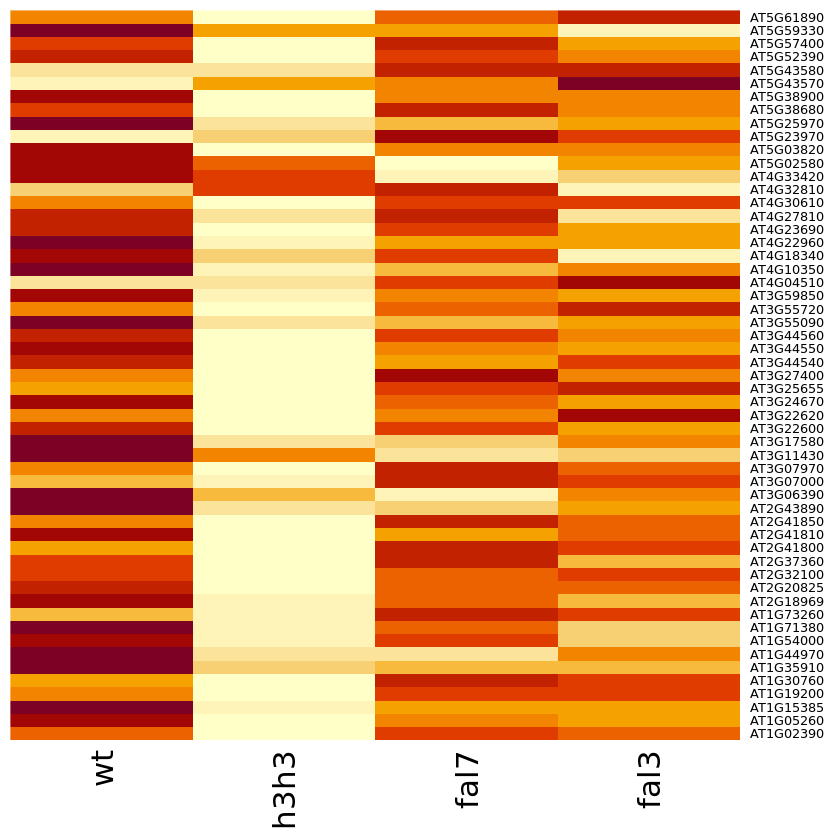

In [12]:
#all sig genes
heatmap(de_sub_av-rowMeans(de_sub_av[,(c(1,2))]), Rowv=NA, Colv=NA)

In [13]:
#bulk samples
bulk_ein_yda = counts_to_reads_df("/home/robotmessenger810/sc_analysis/data/bulk_data/Col_h3h3_ein2_yda_KI")
#893 and 894 are same T1, 895 and 896 are distinct T1s

[1] "893_1_YDA-KI_S1_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "893_2_YDA-KI_S24_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "894_1_YDA-KI_S7_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "894_2_YDA-KI_S16_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "895_1_YDA-KI_S23_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "895_2_YDA-KI_S20_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "896_1_YDA-KI_S15_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "896_2_YDA-KI_S6_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_1_S21_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_2_S26_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_3_S14_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_4_S9_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_5_S2_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "Col_6_S12_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "ein2_1_S28_R1_001_UMIAligned.outsorted_dedup.bam_counts"
[1] "ein2_2_S13_R1_001_UMIAligned

In [14]:
ein2_yda = bulk_ein_yda[,c(9:14, 21:26, 15:20, 1:8)]

In [15]:
head(ein2_yda)

,V9,V10,V11,V12,V13,V14,V21,V22,V23,V24,⋯,V19,V20,V1,V2,V3,V4,V5,V6,V7,V8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AT1G01010,0,1,1,6,1,8,2,4,3,4,⋯,0,3,2,12,3,1,4,2,8,3
AT1G01020,2,8,13,10,8,17,17,15,24,13,⋯,5,6,7,70,19,7,20,18,17,22
AT1G01030,0,0,0,1,1,1,1,5,2,1,⋯,0,0,0,6,1,1,2,2,2,3
AT1G01040,1,25,24,41,25,49,48,62,52,34,⋯,23,25,4,170,49,15,68,38,46,80
AT1G01046,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
AT1G01050,9,64,76,83,54,153,72,126,135,67,⋯,39,43,23,375,97,45,123,99,108,141


[1] 32838    26

[1] 23388    26

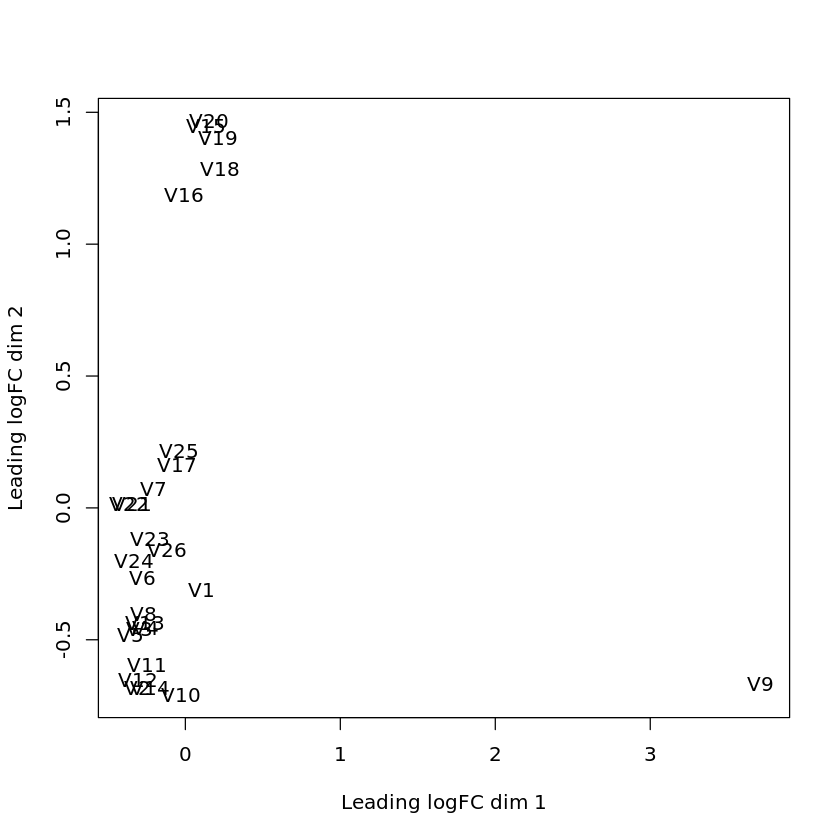

In [60]:

#make DGElist
x3 <- DGEList(counts = ein2_yda, genes = rownames(ein2_yda))


#reads per library uniquely mapped to a gene:

#make cpm and lcpm
cpm <- cpm(x3)
lcpm <- cpm(x3, log=TRUE)

#keep only genes that are expressed. "Expressed" here means counts observed in at least 3 samples
dim(x3)
keep.exprs <- rowSums(cpm>0)>=3
x3 <- x3[keep.exprs,, keep.lib.sizes=FALSE]
dim(x3) #compare to dim(x) above

#normalize data after removing low expressed genes
x3 <- calcNormFactors(x3)

#cpm, lcpm of normalized values
cpm <- cpm(x3)
lcpm <- cpm(x3, log=TRUE)

plotMDS(lcpm)


In [ ]:
lcpm[rownames(lcpm) %in% unlist(bulk_pb_intersection$x),c("V15", "V16", "V18", "V19","V20", "V17", "V9", "V10")]

In [54]:
lcpm[genes,c("V15", "V16", "V18", "V19","V20", "V17", "V9", "V10")]


,V15,V16,V18,V19,V20,V17,V9,V10
AT2G18969,2.2775491,0.5297989,1.3703685,2.3034909,1.5887984,1.306406,0.5297989,0.5297989
AT3G11430,5.2170061,4.3050673,4.6998263,4.5937600,2.6174174,5.448041,3.1062006,3.5313972
AT3G17580,1.6535791,2.6218962,2.4434638,2.7404739,2.9450018,3.553226,3.1062006,3.5313972
AT4G04510,0.5297989,0.5297989,0.5297989,1.6736098,0.5297989,1.306406,0.5297989,0.5297989
AT4G33420,4.6597751,3.8082494,4.7618483,4.2408965,2.9450018,3.786381,3.1062006,3.6811668
AT5G02580,4.2069375,3.6961722,3.6848309,0.5297989,3.8029999,5.885006,4.9123284,4.6710732


In [61]:
#pool all YDA_KIs
ein2_de_sub_av = cbind(rowMeans(lcpm[,c(1:6)]), rowMeans(lcpm[,c(7,8,10,11,12)]), rowMeans(lcpm[,c(13:18)]), rowMeans(lcpm[,c(19:26)]))

#only first T1
ein2_de_sub_av = cbind(rowMeans(lcpm[,c(1:6)]), rowMeans(lcpm[,c(7,8,10,11,12)]), rowMeans(lcpm[,c(13:18)]), rowMeans(lcpm[,c(19:23)]))

ein2_de_sub_av = ein2_de_sub_av[rownames(ein2_de_sub_av) %in% bulk_pb_intersection[,2],]

In [62]:
colnames(ein2_de_sub_av) = c("wt", "h3h3", "ein2", "yda_KI")
head(ein2_de_sub_av)


,wt,h3h3,ein2,yda_KI
AT1G02390,3.807513,2.246592,1.156623,3.761628
AT1G05260,7.416618,6.863148,3.358124,7.277680
AT1G15385,3.141328,1.862664,1.091428,3.493874
AT1G19200,4.364874,3.582084,3.036866,4.152638
AT1G30760,5.035849,3.749189,3.764495,3.776669
AT1G35910,5.243221,3.940065,2.769490,5.336540


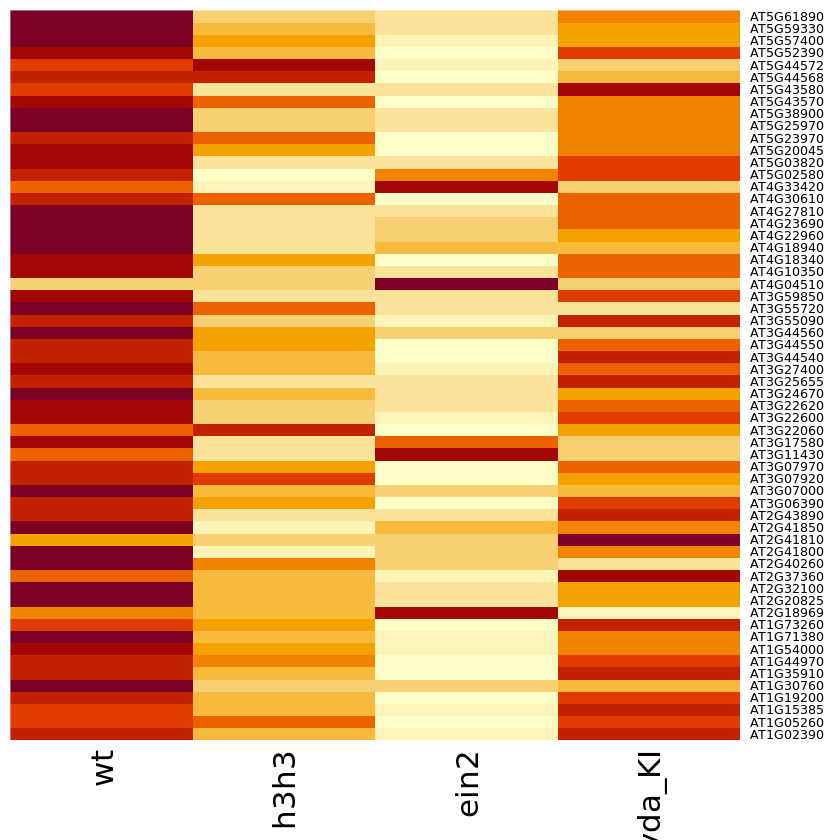

In [63]:
heatmap(ein2_de_sub_av-rowMeans(ein2_de_sub_av[,(c(1,2))]), Rowv=NA, Colv=NA)

In [58]:
rowMeans(ein2_de_sub_av[,(c(1,2))])

AT1G02390 AT1G05260 AT1G15385 AT1G19200 AT1G30760 AT1G35910 AT1G44970 AT1G54000 
3.0270528 7.1398827 2.5019959 3.9734790 4.3925189 4.5916430 7.0727780 3.6567323 
AT1G71380 AT1G73260 AT2G18969 AT2G20825 AT2G32100 AT2G37360 AT2G41800 AT2G41810 
2.8655808 5.1965494 1.4652611 3.4941342 1.8307106 1.0428595 1.2995417 0.9351084 
AT2G41850 AT2G43890 AT3G06390 AT3G07000 AT3G07970 AT3G11430 AT3G17580 AT3G22600 
1.3772259 0.8447678 3.2956531 0.7847583 5.9438919 3.4957176 2.3965905 3.9157866 
AT3G22620 AT3G24670 AT3G25655 AT3G27400 AT3G44540 AT3G44550 AT3G44560 AT3G55090 
3.1339926 2.7510868 1.3443341 6.5502423 5.0777294 6.1758218 2.2077247 3.5271607 
AT3G55720 AT3G59850 AT4G04510 AT4G10350 AT4G18340 AT4G22960 AT4G23690 AT4G27810 
1.0609138 3.2419837 0.5297989 2.0388354 2.9849922 0.8242805 6.0904919 1.0878704 
AT4G30610 AT4G32810 AT4G33420 AT5G02580 AT5G03820 AT5G23970 AT5G25970 AT5G38900 
4.2176532 3.5763625 3.4367063 3.1370022 3.0920135 4.9918961 2.7361564 2.1534029 
AT5G43570 AT5G43580 AT5G52390 AT5G57400 AT5G59330 AT5G61890 
2.6330761 0.8944114 7.4149148 1.3717668 2.6547089 1.8542006

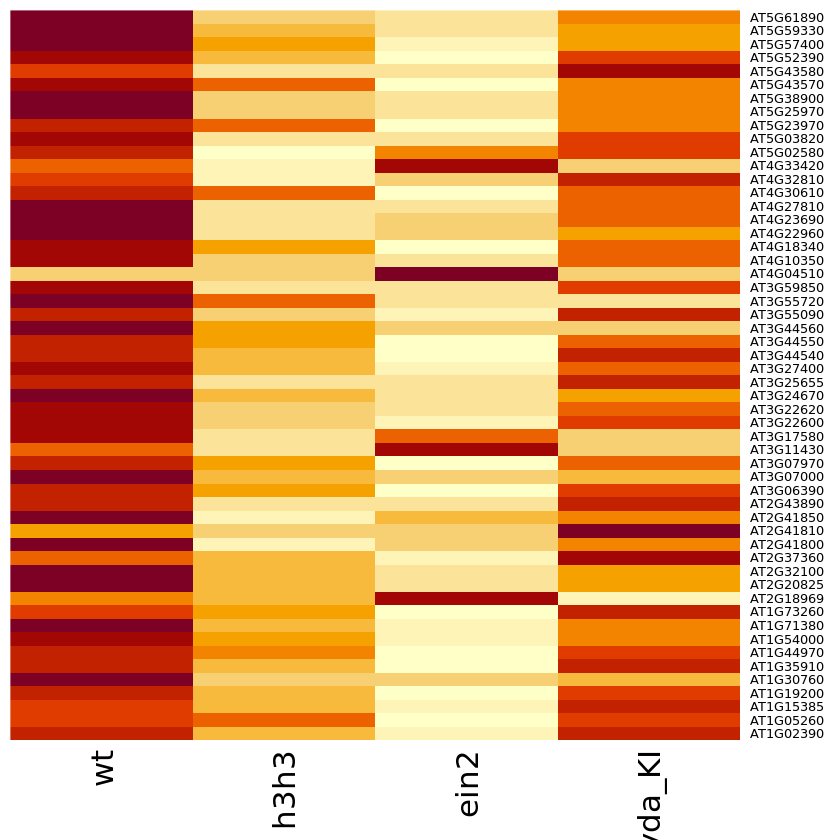

In [56]:
heatmap(ein2_de_sub_av-colMeans(ein2_de_sub_av[,(c(1,2))]), Rowv=NA, Colv=NA)

In [31]:
fcs_ein2 = data.frame(ein2_de_sub_av-rowMeans(ein2_de_sub_av[,(c(1,2))]))
dim(fcs_ein2)

[1] 54  4

In [33]:
genes = rownames(fcs_ein2[fcs_ein2$ein2 > 0,])

In [64]:
ein2_de_sub_av[genes,]

,wt,h3h3,ein2,yda_KI
AT2G18969,1.4822242,1.4482979,1.5627352,1.3815362
AT3G11430,3.9635624,3.0278729,4.4801863,3.1869622
AT3G17580,3.2256941,1.5674869,2.6596068,1.8303650
AT4G04510,0.5297989,0.5297989,0.8498685,0.5297989
AT4G33420,3.7103476,3.1630651,4.0336921,3.3095770
AT5G02580,4.7887946,1.4852098,3.6342910,4.3318489


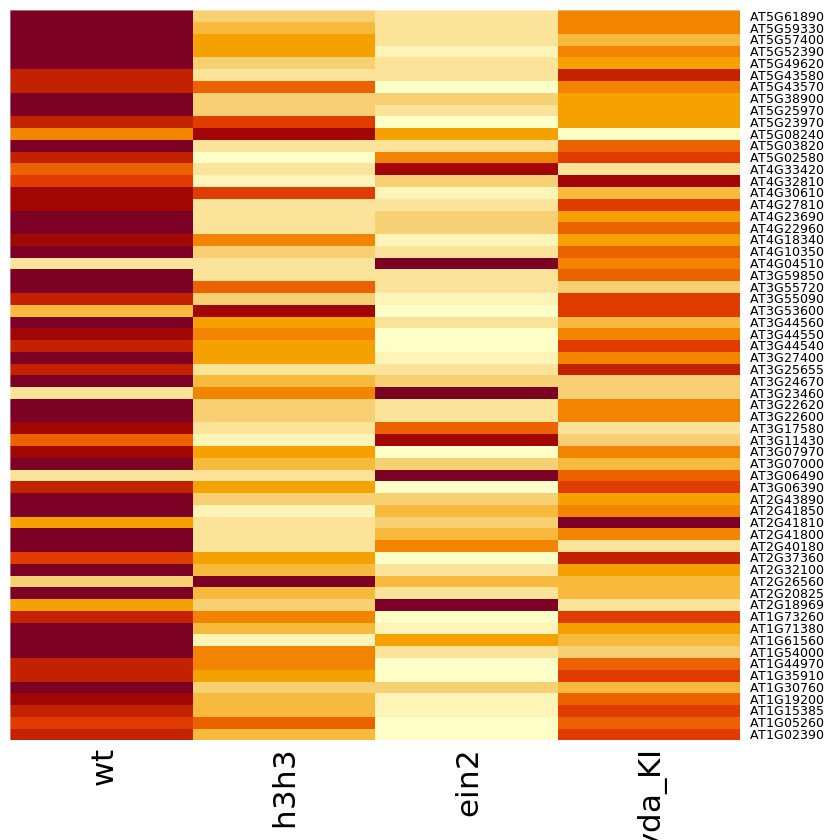

In [35]:
#pool most YDA_KIs
ein2_de_sub_av = cbind(rowMeans(lcpm[,c(1:6)]), rowMeans(lcpm[,c(7,8,10,11,12)]), rowMeans(lcpm[,c(13:18)]), rowMeans(lcpm[,c(19, 20, 23:26)]))

ein2_de_sub_av = ein2_de_sub_av[rownames(ein2_de_sub_av) %in% bulk_pb_intersection[,2],]

colnames(ein2_de_sub_av) = c("wt", "h3h3", "ein2", "yda_KI")

heatmap(ein2_de_sub_av-rowMeans(ein2_de_sub_av[,(c(1,2))]), Rowv=NA, Colv=NA)

In [37]:
nev = read.csv("/home/robotmessenger810/sc_analysis/data/bulk_data/Col_h3h3_nev/Col_h3h3_nev.csv")

In [72]:
nev_sub_av = nev[nev$gene %in% bulk_pb_intersection[,2],2:4]

In [46]:
head(nev_sub_av)

,Col0,hae3hsl23,nev3
,<dbl>,<dbl>,<dbl>
155,3.657514,2.266136,5.468720
480,7.038787,5.522285,2.734859
1658,4.740269,2.388054,6.538915
2081,4.306824,3.176498,5.127287
3333,4.442897,3.405230,5.065559
3955,6.488187,4.942899,5.275875


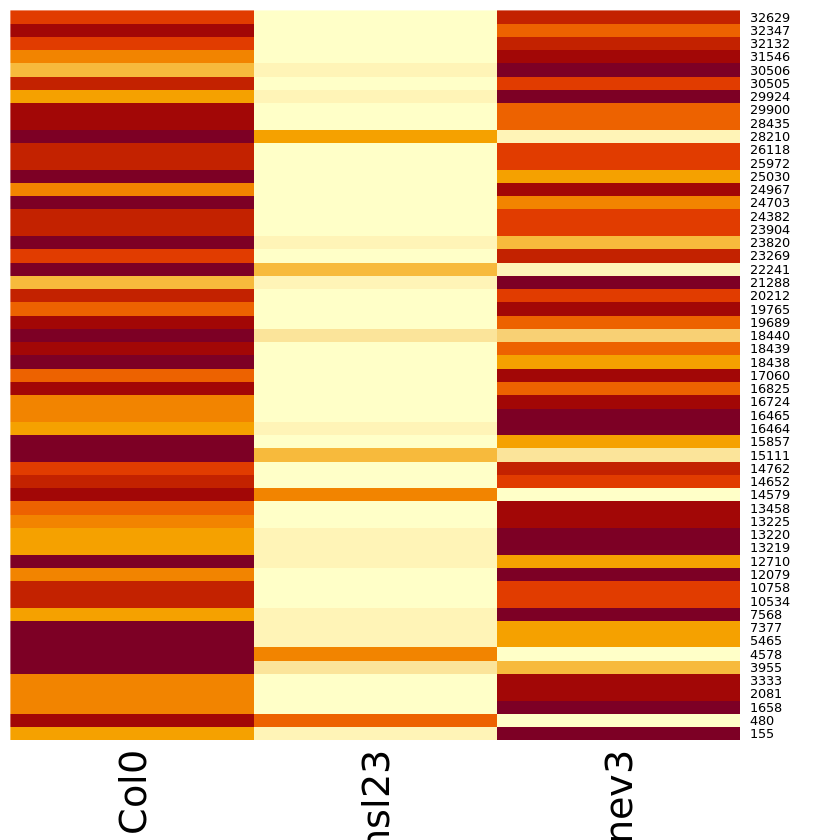

In [73]:
heatmap(as.matrix(nev_sub_av-rowMeans(nev_sub_av[,(c(1,2))])), Rowv=NA, Colv=NA)

In [50]:
nev_sub_av-rowMeans(nev_sub_av[,(c(1,2))])

,Col0,hae3hsl23,nev3
,<dbl>,<dbl>,<dbl>
155,0.6956892,-0.6956892,2.50689509
480,0.7582512,-0.7582512,-3.54567696
1658,1.1761073,-1.1761073,2.97475340
2081,0.5651627,-0.5651627,1.38562562
3333,0.5188335,-0.5188335,1.14149587
3955,0.7726440,-0.7726440,-0.43966825
4578,1.1289420,-1.1289420,-3.38073971
5465,0.9360614,-0.9360614,-0.27467362
6233,1.0967628,-1.0967628,5.55360517
